## Aim
The aim of this notebook is to test whether the placement of the activation function (before or after the sub-sampling operation) has any effect. Although minimal for this example, it had an impact, resulting in a higher accuracy to place the activation function after the max-pooling operations. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import datasets, transforms

In [2]:
# Define the hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 3

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Using GPU: {}".format(use_cuda))

Using GPU: False


In [4]:
# Set seed during training for reproducibility
torch.manual_seed(0)
if use_cuda:
    torch.cuda.manual_seed(0)

In [5]:
# Get MNIST data
train_dat = datasets.MNIST("data/", train=True, transform=transforms.ToTensor(), download=True)#, transform=transform)
test_dat = datasets.MNIST("data/", transform=transforms.ToTensor(), train=False)#, transform=transform)
# train_dat[index][0] -> Image
# train_dat[index][1] -> Label

In [6]:
# Create the dataloaders for iterating over the datasets
train_loader = DataLoader(train_dat, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dat, batch_size=BATCH_SIZE, shuffle=False)
# Add validation set and sampler

In [7]:
# Note: Maximum pooling is used, unlike the original architecture where average pooling is used
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.lenet = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5, stride=1, padding=2),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        nn.Flatten(),
                        nn.Linear(in_features=400, out_features=120),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=84,  out_features=10)
                     )
    def forward(self,x):
        return self.lenet(x)

In [8]:
# Note: Maximum pooling is used, unlike the original architecture where average pooling is used
class LeNet5v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lenet = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5, stride=1, padding=2),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        nn.ReLU(inplace=True),
                        nn.Flatten(),
                        nn.Linear(in_features=400, out_features=120),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=84,  out_features=10)
                     )
    def forward(self,x):
        return self.lenet(x)

In [9]:
def loss_function(pred, y):
    return F.cross_entropy(pred, y)

In [10]:
lenet = LeNet5()
lenet = lenet.to(device=device)

lenet2 = LeNet5v2()
lenet2 = lenet2.to(device=device)

optimizer = optim.Adam(lenet.parameters(), lr=LEARNING_RATE)
optimizer2 = optim.Adam(lenet2.parameters(), lr=LEARNING_RATE)

training_loss = []
training_loss2 = []

# Start training
lenet.train()
lenet2.train()
for epoch in range(EPOCHS):
    for i, (x,y) in enumerate(train_loader): 
        x = x.to(device=device, dtype=torch.float32)  # Use GPU
        y = y.to(device=device, dtype=torch.long)     #  if applicable
        
        # Forward pass through the network
        scores = lenet(x) 
        scores2 = lenet2(x) 
        # Compute the loss of the predictions
        loss = loss_function(scores, y)
        loss2 = loss_function(scores2, y)
        
        # Set the gradients to zero
        optimizer.zero_grad()
        optimizer2.zero_grad()
        
        # Compute the gradients of the loss with respect to the weights
        loss.backward()
        loss2.backward()
        
        # Update the weights of the model (Back-propagation)
        optimizer.step()
        optimizer2.step()
        
        if i % 100 == 0:
            print('Iteration {}, loss = {:.2f}'.format(epoch*1000 + i, loss.item()))
            training_loss.append(loss.item())
            print('Iteration {}, loss2 = {:.2f}'.format(epoch*1000 + i, loss2.item()))
            training_loss2.append(loss2.item())

Iteration 0, loss = 2.30
Iteration 0, loss2 = 2.30
Iteration 100, loss = 0.34
Iteration 100, loss2 = 0.38
Iteration 200, loss = 0.38
Iteration 200, loss2 = 0.26
Iteration 300, loss = 0.15
Iteration 300, loss2 = 0.18
Iteration 400, loss = 0.10
Iteration 400, loss2 = 0.09
Iteration 500, loss = 0.10
Iteration 500, loss2 = 0.08
Iteration 600, loss = 0.07
Iteration 600, loss2 = 0.09
Iteration 700, loss = 0.03
Iteration 700, loss2 = 0.06
Iteration 800, loss = 0.07
Iteration 800, loss2 = 0.06
Iteration 900, loss = 0.08
Iteration 900, loss2 = 0.08
Iteration 1000, loss = 0.01
Iteration 1000, loss2 = 0.02
Iteration 1100, loss = 0.09
Iteration 1100, loss2 = 0.12
Iteration 1200, loss = 0.06
Iteration 1200, loss2 = 0.04
Iteration 1300, loss = 0.08
Iteration 1300, loss2 = 0.10
Iteration 1400, loss = 0.02
Iteration 1400, loss2 = 0.03
Iteration 1500, loss = 0.02
Iteration 1500, loss2 = 0.02
Iteration 1600, loss = 0.02
Iteration 1600, loss2 = 0.03
Iteration 1700, loss = 0.04
Iteration 1700, loss2 = 0.0

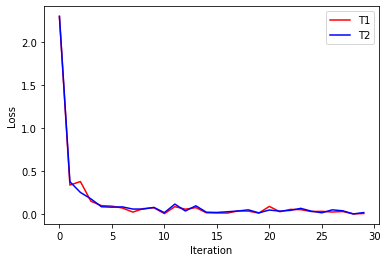

In [16]:
plt.plot(training_loss, 'r')
plt.plot(training_loss2, 'b')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['T1','T2'])
plt.show()

In [17]:
# Evaluate the model
lenet.eval()

num_correct = 0
num_samples = 0
lenet.eval()  # set model to evaluation mode
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device, dtype=torch.float32)  # Use GPU
        y = y.to(device=device, dtype=torch.long)     #  if applicable
        
        scores = lenet(x)
        
        _, preds = scores.max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        
    accuracy = float(num_correct) / num_samples
    print('Correct predictions: %d / %d, with accuracy = (%.2f)' % (num_correct, num_samples, 100 * accuracy))

Correct predictions: 9842 / 10000, with accuracy = (98.42)


In [18]:
# Evaluate the model
lenet2.eval()

num_correct = 0
num_samples = 0
lenet2.eval()  # set model to evaluation mode
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device, dtype=torch.float32)  # Use GPU
        y = y.to(device=device, dtype=torch.long)     #  if applicable
        
        scores = lenet2(x)
        
        _, preds = scores.max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        
    accuracy = float(num_correct) / num_samples
    print('Correct predictions: %d / %d, with accuracy = (%.2f)' % (num_correct, num_samples, 100 * accuracy))

Correct predictions: 9862 / 10000, with accuracy = (98.62)


In [ ]:
# Save weights if desired
torch.save(lenet.state_dict(), 'model.pt')